## 0.Getting Setup

In [1]:
import torch
import torchvision

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 21.36 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Getting Data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2.Creating effNetB2 feature extractor

In [ ]:
#getting pretrain weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

#setup pretrain model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

#get transform
effnet_transforms = effnetb2_weights.transforms()

#freeze base layer
for parms in effnetb2.parameters():
  parms.requires_grad = True

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 97.9MB/s]


In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
effnetb2.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408, out_features= 3))

### 2.1 Creating the fn to create effnet feature extracator

In [ ]:
def create_effnetb2_model(num_classes:int=3):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights= weights)
  transforms = weights.transforms()

  #freeze base layer
  for parms in model.parameters():
    parms.requires_grad = False

  #changing classifier head
  model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                  nn.Linear(in_features=1408, out_features= num_classes))

  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

In [ ]:
summary(model=effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [ ]:
#lets train
from going_modular.going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= effnetb2.parameters(), lr=1e-3)

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9683 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8523
Epoch: 2 | train_loss: 0.6955 | train_acc: 0.8542 | test_loss: 0.6128 | test_acc: 0.9347
Epoch: 3 | train_loss: 0.5544 | train_acc: 0.8750 | test_loss: 0.5000 | test_acc: 0.9159
Epoch: 4 | train_loss: 0.4527 | train_acc: 0.9000 | test_loss: 0.4456 | test_acc: 0.9284
Epoch: 5 | train_loss: 0.4283 | train_acc: 0.8792 | test_loss: 0.3828 | test_acc: 0.9472
Epoch: 6 | train_loss: 0.3680 | train_acc: 0.9167 | test_loss: 0.3546 | test_acc: 0.9563
Epoch: 7 | train_loss: 0.3554 | train_acc: 0.9146 | test_loss: 0.3177 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3400 | train_acc: 0.9146 | test_loss: 0.3237 | test_acc: 0.9534
Epoch: 9 | train_loss: 0.3819 | train_acc: 0.8542 | test_loss: 0.2926 | test_acc: 0.9500
Epoch: 10 | train_loss: 0.3817 | train_acc: 0.8771 | test_loss: 0.3183 | test_acc: 0.9472


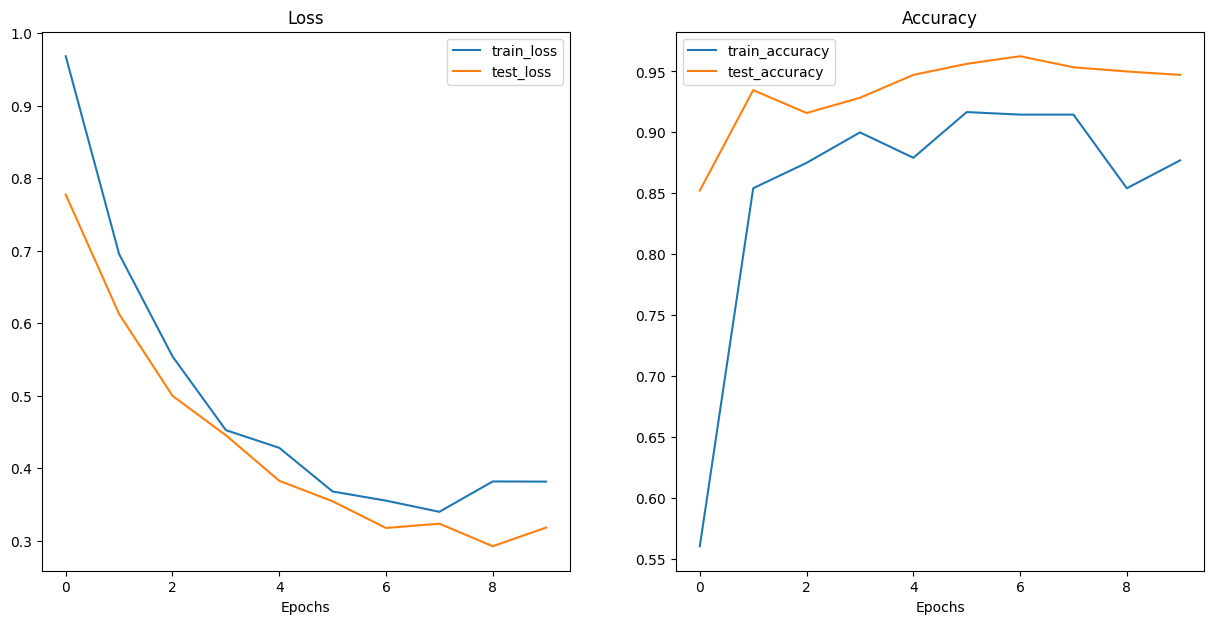

In [ ]:
#loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.3182752162218094,
 'test_acc': 0.947159090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 3.Creating ViT feature extractor

In [ ]:
#checking head layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  model = torchvision.models.vit_b_16(weights=weights)
  transforms = weights.transforms()

  #freeze base model
  for params in model.parameters():
    params.requires_grad = False

  #changing classifier head
  model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))

  return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 127MB/s]


In [ ]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5769 | train_acc: 0.8250 | test_loss: 0.2182 | test_acc: 0.9625
Epoch: 2 | train_loss: 0.1965 | train_acc: 0.9500 | test_loss: 0.1196 | test_acc: 0.9750
Epoch: 3 | train_loss: 0.1405 | train_acc: 0.9563 | test_loss: 0.0907 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.1581 | train_acc: 0.9354 | test_loss: 0.0780 | test_acc: 0.9812
Epoch: 5 | train_loss: 0.1027 | train_acc: 0.9708 | test_loss: 0.0783 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.0865 | train_acc: 0.9771 | test_loss: 0.0712 | test_acc: 0.9750
Epoch: 7 | train_loss: 0.0968 | train_acc: 0.9479 | test_loss: 0.0674 | test_acc: 0.9750
Epoch: 8 | train_loss: 0.0652 | train_acc: 0.9875 | test_loss: 0.0699 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.1185 | train_acc: 0.9583 | test_loss: 0.0646 | test_acc: 0.9750
Epoch: 10 | train_loss: 0.0547 | train_acc: 0.9917 | test_loss: 0.0797 | test_acc: 0.9631


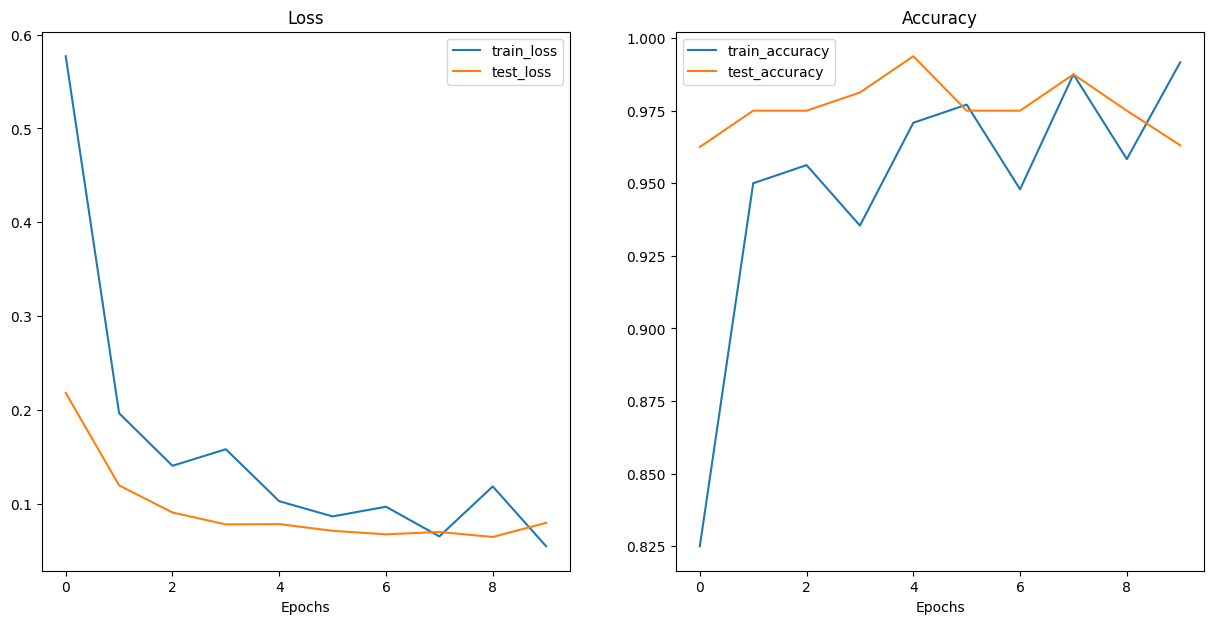

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.07965652598068118,
 'test_acc': 0.9630681818181819,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 4.Making Prediction with train model and time them

In [ ]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3886015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3401466.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1683426.jpg')]

sushi


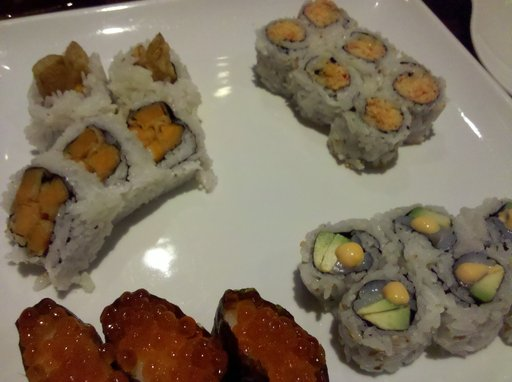

In [ ]:
from PIL import Image
print(test_data_paths[1].parent.stem) #add .parent more if you want to get other folder
Image.open(test_data_paths[1])

In [ ]:
#Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    #empty list to store predection dictionary
    pred_list = []

    #loop through target path
    for path in tqdm(paths):
      #dict to store prediction of every image
      pred_dict = {}

      #get the path and class
      pred_dict['image_path'] = path
      class_name = path.parent.stem
      pred_dict['class_name'] = class_name

      start_time = timer()

      img = Image.open(path)

      transformed_image = transform(img).unsqueeze(0).to(device)

      model.to(device)
      model.eval()

      with torch.inference_mode():
        pred_logit = model(transformed_image)
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1)
        pred_class = class_names[pred_label.cpu()]

        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_class"] = pred_class

        end_time = timer()
        pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

### 4.1 Timing prediction for effnetb2

In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dicts[1]

{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
 'class_name': 'sushi',
 'pred_prob': 0.6209,
 'pred_class': 'sushi',
 'time_for_pred': 0.0978,
 'correct': True}

In [ ]:
import pandas as pd
effnetb2_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.8839,sushi,0.2746,True
1,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.6209,sushi,0.0978,True
2,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.6938,sushi,0.0940,True
3,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.7837,sushi,0.1040,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.5691,sushi,0.1139,True


In [ ]:
effnetb2_df['correct'].value_counts()

correct
True     142
False      8
Name: count, dtype: int64

In [ ]:
effnetb2_average_time_per_pred = round(effnetb2_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0988 seconds


In [ ]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.3182752162218094,
 'test_acc': 0.947159090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0988}

### 4.2 Timing prediction for ViT

In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_dicts[1]

{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/472912.jpg'),
 'class_name': 'sushi',
 'pred_prob': 0.8743,
 'pred_class': 'sushi',
 'time_for_pred': 0.3763,
 'correct': True}

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_df = pd.DataFrame(vit_test_pred_dicts)
vit_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9407,sushi,0.6373,True
1,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.8743,sushi,0.3763,True
2,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9643,sushi,0.3945,True
3,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9988,sushi,0.5497,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.6346,sushi,0.5532,True


In [ ]:
vit_df['correct'].value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4221 seconds


In [ ]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.07965652598068118,
 'test_acc': 0.9630681818181819,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.4221}

## 5.Comparing model results, prediction time and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.318275,94.72,7705221,29,0.0988,EffNetB2
1,0.079657,96.31,85800963,327,0.4221,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.250276,1.016786,11.135432,11.275862,4.272267


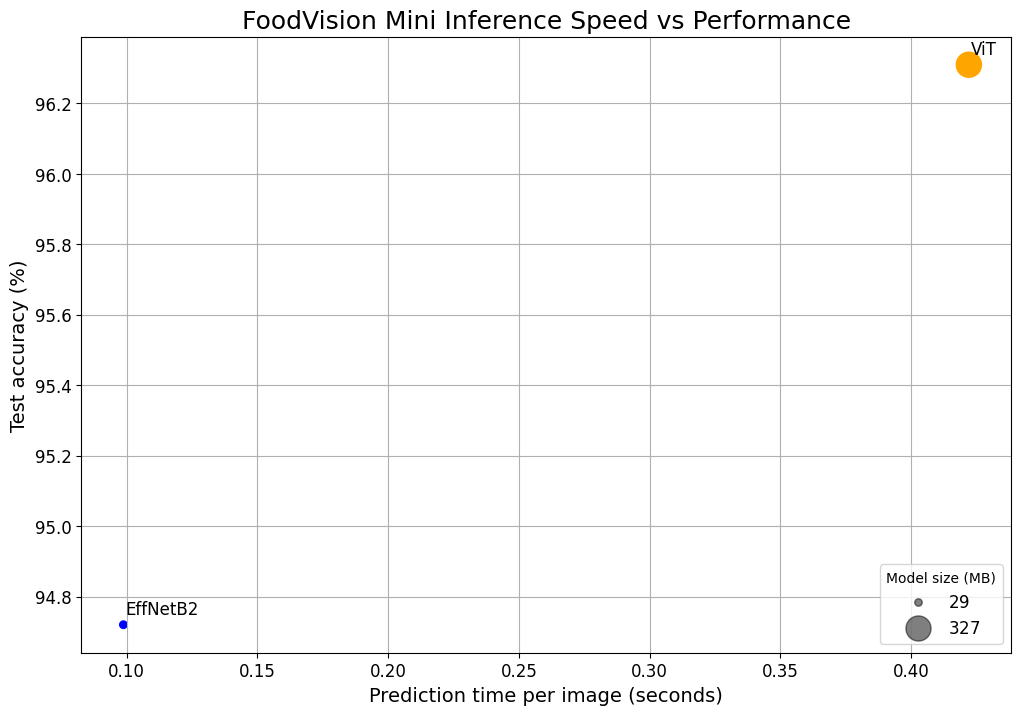

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Show the figure
plt.show()

## 6.Giving Life to FoodVision Mini

In [ ]:
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.9 M

### 6.1 Creating fn to map input and outpur
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken

In [ ]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)


  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

#list of all image file
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

#randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

#open a target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/3886015.jpg

Prediction label and probability dictionary: 
{'pizza': 0.032047420740127563, 'steak': 0.08403781801462173, 'sushi': 0.8839147090911865}
Prediction time: 0.09059 seconds


### 6.2 List of example image

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/2572488.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/715227.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg']]

### 6.3 Building a gradio interface

In [ ]:
import gradio as gr

title="FoodVision Mini"
Description = "Classify image pizza, steak and sushi"
article = "Comming Soon ........"

#creat gradio demo
demo = gr.Interface(fn=predict,
             inputs=gr.Image(type="pil"),
             outputs=[gr.Label(num_top_classes=3, label="Predictions"), #label component
                      gr.Number(label="Prediction time (s)")],#number component
             examples=example_list,
             title=title,
             description=Description,
             article=article)

#lunch demo
demo.launch(debug=False,  #print error locally
            share=True) #publically sharable url

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://81974082650766da2f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 7.Turning demo into deployable app

### 7.1 Creating demo folder to store food vision mini file

In [ ]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/

### 7.2 Creating folder of example image

In [ ]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/592799.jpg'], ['examples/3622237.jpg']]

### 7.3 Moving our train model in demo folder

In [ ]:
import shutil

effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)
  print(f"[INFO] Model move complete.")
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 7.4 Turning our model into python script

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Overwriting demos/foodvision_mini/model.py


### 7.5 Turning gradio app into python script

In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

#setup class name
class_names = ["pizza", "steak", "sushi"]

#creat a model and model_transformation
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

#load save weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),
    )
)

#prediction fn
def predict(img) -> Tuple[Dict, float]:
  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  #gradio recieve result in dict
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_time

# gradio app
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."

#example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict,
             inputs=gr.Image(type="pil"), # what are the inputs?
             outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                      gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
             # Create examples list from "examples/" directory
             examples=example_list,
             title=title,
             description=description)

demo.lunch()

Writing demos/foodvision_mini/app.py


### 7.6 Writing requirement.txt

In [ ]:
print(f"Torch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"Gradio Version: {gr.__version__}")

Torch Version: 2.3.0+cu121
Torchvision Version: 0.18.0+cu121
Gradio Version: 4.37.2


In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.3.0
torchvision==0.18.0
gradio==4.37.2

Writing demos/foodvision_mini/requirements.txt


## 8.Deploying FoodVision Mini into hugging face space

In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   requirements.txt
examples


### 8.1 Downloading zipfile

In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 52%)
  adding: examples/ (stored 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>